In [1]:
import matplotlib.pyplot as plt
import numpy as np
import serial

In [ ]:
#---------------------------------------------------------------
# Questions
#---------------------------------------------------------------
# 1. What is the structure of the vector R? Should it be seperate from the inductance? 
# 2. What does the paper mean by diagonal vector R?
# 3. Why does the paper say R is a square matrix?
# 4. Should we ignore imaginary part of complex matrices? Or should we use abs and ignore phase instead?
# 5. Double check if discarding right half of FFT result is doing the correct thing.
# 6. Double check if dot product is doing the right thing, because not working unless if arrays flattened.


In [10]:
#---------------------------------------------------------------
# Closing relays inorder to use SRC Voltage
#---------------------------------------------------------------
with serial.Serial("/dev/serial0", 115200, timeout=1) as ser:
    ser.reset_input_buffer() # clear input serial buffer
    ser.reset_output_buffer() # clear ouput serial buffer

    ser.write(b"-p p 5555\r") # get access to testing mode
    ser.write(b"-p a 3\r") # get access to factory testing mode
    ser.write(b"-m1\r") # reset faults
    ser.write(b"-sd8\r") # check mode. Must be in standby mode.
    
    # ser.write(b"-f f ?\r") # help on factory mode
    ser.write(b"-f f test_io\r") # put device in IO test mode
    # ser.write(b"-f i ?\r") # help on IO factory mode
    ser.write(b"-f i src_1=1\r") # close src_1 relay
    ser.write(b"-f i src_2=1\r") # close src_2 relay

    ser.close()

In [4]:
#---------------------------------------------------------------
# Reading data from Powerstar 10 card
#---------------------------------------------------------------

# Setup primary UART (miniUART) and read from Powerstar card
with serial.Serial("/dev/serial0", 115200, timeout=1) as ser:
    ser.reset_input_buffer() # clear input serial buffer
    ser.reset_output_buffer() # clear output serial buffer

    ser.write(b"-twh\r") # request headings for signals from Powerstar 10 card
    headings = [((x.strip()).strip(',')).split(',') for x in (((ser.read(1024)).strip()).strip('\r')).split('\r')] # read serial data in response to headings request. strip() necessary for any leading and trailing spaces in data
    print(headings)

    ser.write(b"-twrh\r"); ser.read(1024); # set to high resolution logging fadc = 10kHz
    # ser.write(b"-twrl\r"); ser.read(1024); # set to low resolution logging fadc = 1kHz

    ser.write(b"-tw\r") # request signals from Powerstar 10 card
    data = [((x.strip()).strip(',')).split(',') for x in (((ser.read(10000)).strip()).strip('\r')).split('\r')] # read serial data
    data = np.array(data[:-1]) # discard last list in data. Usually no complete.
    data = data.astype(np.float) # convert data array of strings to array of floats 
    data = np.transpose(data) # transpose data so that a list at each row is a buffer for a partricular measured quantity
    # print(data)

    src_v1 = data[0]/12 # source voltage
    src_i1 = data[2]/12 # source current

    ser.close()

[['Src Volts SIG', 'Inv Volts SIG', 'Src Amps SIG', 'Inv Amps SIG', 'Src V d', 'Src V q'], [''], ['Cmd Ok']]


<Container object of 3 artists>

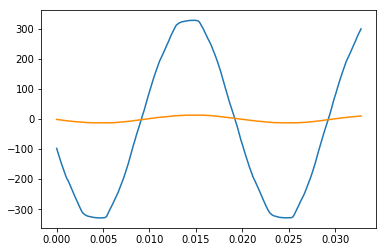

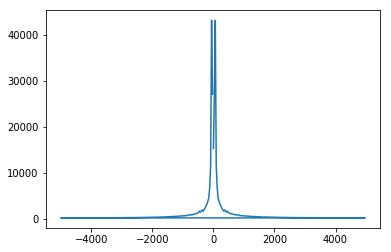

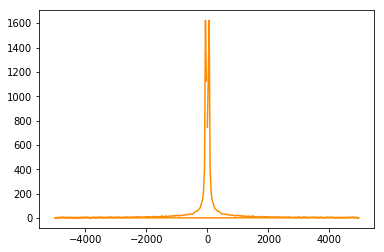

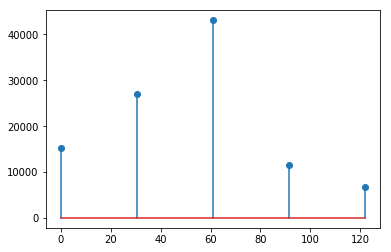

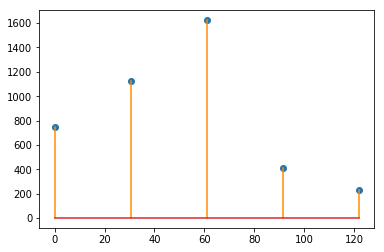

In [5]:
#---------------------------------------------------------------
# Performing FFT
#---------------------------------------------------------------

fadc = float(10000)                                 # sampling frequency of ADC. 1kHz for low resolution; 10kHz for high resolution.
nsamples = len(src_v1)                               # number of samples
tlen = nsamples/fadc
trunc = 5

t = np.linspace(0,tlen,nsamples) # generate time axis for signal

plt.plot(t, src_v1)
plt.plot(t, src_i1, color='darkorange')

SRC_V1 = np.fft.fft(src_v1) # perform FFT on source voltage
SRC_I1 = np.fft.fft(src_i1) # perform FFT on source voltage

freq = np.fft.fftfreq(len(t), 1/fadc) # obtain frequency axis

plt.figure(); plt.plot(freq, abs(SRC_V1))
plt.figure(); plt.plot(freq, abs(SRC_I1), color='darkorange')

plt.figure(); plt.stem(freq[:trunc], abs(SRC_V1)[:trunc]) # zoom in
plt.figure(); plt.stem(freq[:trunc], abs(SRC_I1)[:trunc], 'darkorange') # zoom in


In [ ]:
# --------------------------------------------------------
# Signal simulation
# --------------------------------------------------------

def simulateSignal(f0, A0, fmod, Amod, tlen, fs):
    ''' 
    Simulates a signal with the following paramters
    
    f0: fundamental frequency
    A0: amplitude of fundamental frequency 
    fmod: frequency of amplitude modulation
    Amod: amplitude of modulating signal
    tlen: time duration of signal (measurement)
    fs: sampling rate of adc
    
    Returns: array of simulated discrete signal
    
    Note: Signal has third and fifth harmonics of amplitude 1/10 and 1/15 of the fundamental frequency amplitude respectively.
    Change function as desired.
    '''
    
    t = np.linspace(0,tlen,int(fs*tlen)) # generate time axis for signal
    
    xmod = (A0 + Amod*np.sin(2*np.pi*fmod*t)) # generate modulating waveform
    x = np.sin(2*np.pi*f0*t) + (1/10)*np.sin(2*np.pi*3*f0*t) + (1/15)*np.sin(2*np.pi*5*f0*t) # create signal with harmonics
    x = (x*xmod) # modulate signal
    x = x + np.random.normal(0,0.2,int(fs*tlen)) # add noise
    
    return x


In [ ]:
# --------------------------------------------------------
# Autocorrelation to obtain fundamental frequency
# --------------------------------------------------------

def qaudratic_interpolate(a, b, c, b_pos):
    '''
    Performs quadratic interpolation for a set of three adjacent values to obtain location (x-coordinate) of peak
    
    a, b, c: three adjacent samples to which parabola is to be fitted
    b_pos: index of middle sample
    
    Returns: non-discrete 'index' of peak
    '''
    
    return b_pos+(0.5*(a-c)/(a-(2*b)+c))


def compute_f0_acf(x, fs):
    '''
    Determines fundamental frequency of a signal using autocorrelation
    
    Parameters:
    x: signal whose fundamental frequency is to be determined
    fs: sampling frequency of signal x
    
    The ACF of the signal is not actually fully computed or stored to save on space and time.
    Instead, a state machine is used to detect the second peak in the ACF (first peak is always at 0 maximum). 
    
    The states are:
    STATE 0 : set threshold under which value we'll ignore the data. NEW STATE = 1
    STATE 1 : check if signal is above threshold AND slope of the signal is positive. If so, move to STATE 2.
    STATE 2 : check if slope of signal has become negative or zero. If so, peak has been found. Move to STATE 3.
    STATE 3 : exit state machine.
    
    Returns: fundamental frequency (f0)
    '''
    
    thresh = 0
    f0 = 0
    STATE = 0
    sum = 0
    prev_sum = 0
    L = 0 # fundamental frequency period expressed in samples
    
    L_det = 0
    count = 0
    
    R = np.zeros(len(x))
    
    # Autocorrelation with peak detection
    for m in range(len(x)):
        prev_prev_sum = prev_sum
        prev_sum = sum
        sum = 0
        
        for n in range(len(x)-m):
            sum += x[n] * x[n+m] # not storing ACF in order to store memory
                    
        # State machine to obtain three adjacent points around peak for quadratic interpolation
        if (STATE == 2 and (sum - prev_sum) <0): # if gradient change, obtain current and previous two values
            L = qaudratic_interpolate(prev_prev_sum, prev_sum, sum, m-1)
            STATE = 3
            break
            
        if (STATE == 1 and (sum > thresh) and (sum - prev_sum) > 0):
            STATE = 2
            
        if (m == 0):
            thresh = sum * 0.5 # peaks to be detected are above half the first peak (maximum value of ACF)
            STATE = 1
            
    
    # Computing frequency in Hz
    f0 = fs/L;
    
    if (f0 < 40 and f0 > 60):
        print('Fundamental frequency too far from 50 Hz!')
    
    return f0


In [ ]:
# -----------------------------------------------------------
# Magnitude and phase computation for specific frequencies
# -----------------------------------------------------------

def spectral_value(x, f, fs):
    '''
    Uses Discrete Time Fourier Transform formula to obtain the complex value of the signal's spectrum at a particular
    frequency.
    
    Parameters:
    x: time domain signal whose frequency component is to be computed
    f: frequency (Hz) of interest
    fs: sample rate
    
    Returns: complex value of frequency component
    '''
    R = 0 # real part
    I = 0 # complex part
    frel = f/fs # relative frequency. Equation of DTFT actually uses cycles/sample not cycles/sec (i.e. Hz).
    
    for n in range(len(x)):
        R += x[n] * np.cos(2*np.pi*frel*n)
        I += x[n] * np.sin(2*np.pi*frel*n)
    
    return np.complex(R, (-1*I)) # !!! careful not to forget the negative 